In [1]:
import numpy as np
import math
import pandas as pd
import statsmodels.formula.api as smf
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt


In [16]:
files = {
    'Highest filtering': "/maps/forecol/data/Overlays/monte_carlo/results/std0/master_summary_allyears.feather",
    'High filtering': "/maps/forecol/data/Overlays/monte_carlo/results/std1/master_summary_allyears.feather",
    'Medium filtering': "/maps/forecol/data/Overlays/monte_carlo/results/nonan/master_summary_allyears.feather",
}
dfs = {}
for k, v in files.items():
    df = pd.read_feather(v)
    df["agcd"] = df["agbd"] * 0.47
    median_df = df.groupby("mode_vals")["agcd"].median().reset_index()
    dfs[k] = median_df


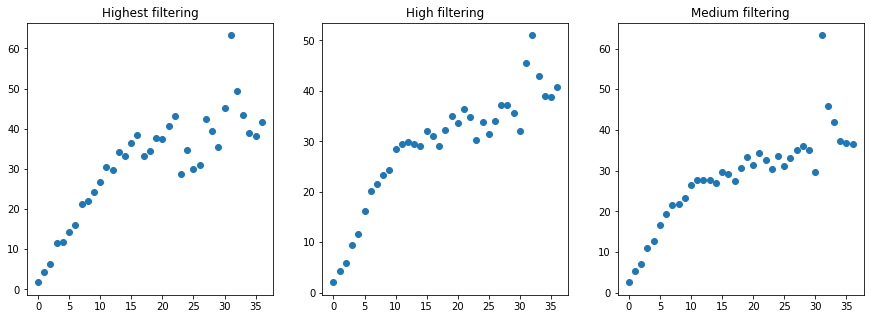

In [17]:
fig, ax = plt.subplots(ncols=len(dfs), figsize=(len(dfs) * 5,5))

for i, item in enumerate(dfs.items()):
    name, df = item
    ax[i].scatter(df.index, df["agcd"])
    ax[i].set_title(name)

Intercept    11.395241
mode_vals     1.038546
dtype: float64
Intercept    11.469971
mode_vals     0.932852
dtype: float64
Intercept    11.090418
mode_vals     0.913415
dtype: float64


Text(0.5, 0.98, 'OLS')

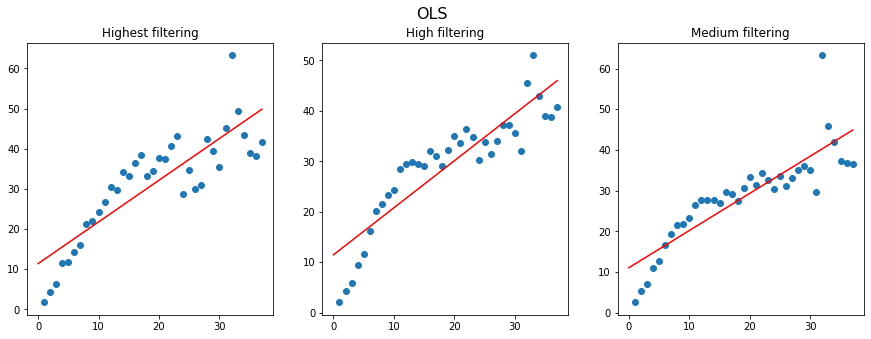

In [18]:
# OLS
fig, ax = plt.subplots(ncols=len(dfs), figsize=(len(dfs) * 5,5))

for i, item in enumerate(dfs.items()):
    name, df = item
    ols = smf.ols('agcd ~ mode_vals', df).fit()
    ax[i].scatter(df['mode_vals'], df['agcd'])
    maxage = df.mode_vals.max()
    print(ols.params)
    ax[i].plot((0, maxage), (ols.params["Intercept"], ols.params["Intercept"] + maxage * ols.params['mode_vals']), color='red')
    ax[i].set_title(name)
fig.suptitle("OLS", fontsize=16)

Intercept            -5.940858
np.log(mode_vals)    13.807765
dtype: float64
Intercept            -4.144830
np.log(mode_vals)    12.418554
dtype: float64
Intercept            -3.468267
np.log(mode_vals)    11.887595
dtype: float64


/tmp/ipykernel_2796467/635388125.py:2: RuntimeWarning: divide by zero encountered in log
  return a + b * np.log(xs)
/tmp/ipykernel_2796467/635388125.py:2: RuntimeWarning: divide by zero encountered in log
  return a + b * np.log(xs)
/tmp/ipykernel_2796467/635388125.py:2: RuntimeWarning: divide by zero encountered in log
  return a + b * np.log(xs)


Text(0.5, 0.98, 'LOG: (a + b ln(x))')

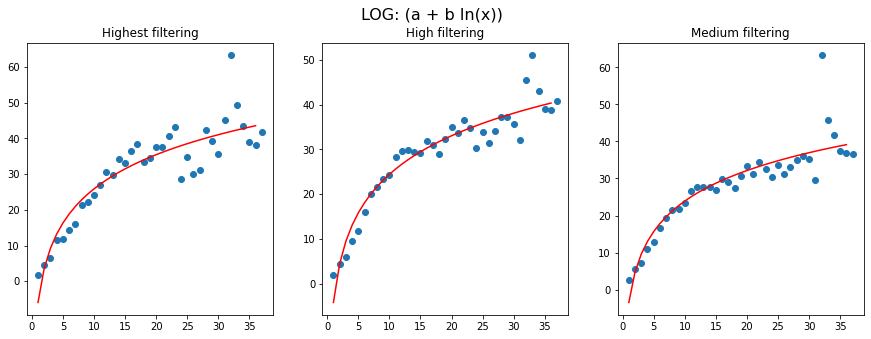

In [20]:
def log_fun(a, b, xs):
    return a + b * np.log(xs)

fig, ax = plt.subplots(ncols=len(dfs), figsize=(len(dfs) * 5,5))

for i, item in enumerate(dfs.items()):
    name, df = item
    ols = smf.ols('agcd ~ np.log(mode_vals)', df).fit()
    ax[i].scatter(df['mode_vals'], df['agcd'])
    maxage = df.mode_vals.max()
    print(ols.params)
    xs = np.arange(0, maxage)
    ax[i].plot(xs, log_fun(ols.params["Intercept"], ols.params["np.log(mode_vals)"], xs), color="red")
    ax[i].set_title(name)
fig.suptitle("LOG: (a + b ln(x))", fontsize=16)

In [22]:
# Get set up with R + python for the more complicated models
import rpy2.robjects.packages as rpackages
from rpy2.robjects.vectors import StrVector, ListVector
from rpy2.robjects import pandas2ri

_SEGMENTED_PACKAGE = "segmented"
_STATS_PACKAGE = "stats"

def _import_package(name):
    utils = rpackages.importr("utils")
    utils.chooseCRANmirror(ind=1)
    if not rpackages.isinstalled(name):
        utils.install_packages(StrVector([name]))
        print("installed!")
    return rpackages.importr(name)

_segmented = _import_package(_SEGMENTED_PACKAGE)
_stats = _import_package(_STATS_PACKAGE)

pandas2ri.activate()


Text(0.5, 0.98, 'EXP: a * (1 - e^(-c * x))')

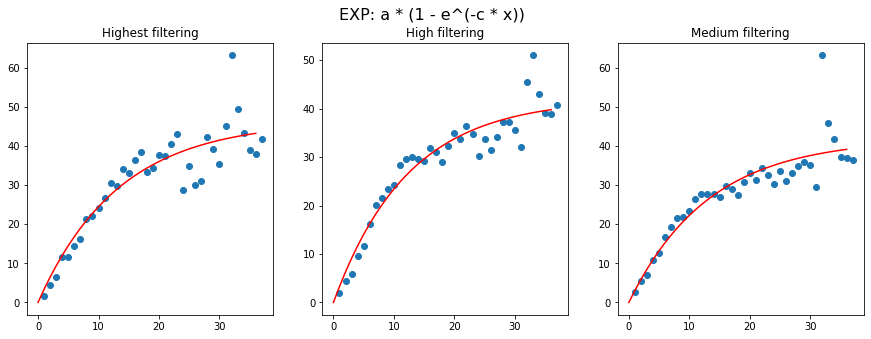

In [24]:
# exponential
def exp_fun(a, c, x):
    return a * (1 - math.e ** (-c * x))

fig, ax = plt.subplots(ncols=len(dfs), figsize=(len(dfs) * 5,5))
starts = {
    0: {"a": 47, "c": 0.07},
    1: {"a": 44, "c": 0.07},
    2: {"a": 43, "c": 0.07},
}
for i, item in enumerate(dfs.items()):
    name, df = item
    r_model = _stats.nls(formula="agcd~a*(1-exp(-c*mode_vals))", data=df, start=ListVector(starts[i]))
    params = r_model.rx2("m").rx2("getPars")()
    ax[i].scatter(df['mode_vals'], df['agcd'])
    maxage = df.mode_vals.max()
    xs = np.arange(0, maxage)
    ax[i].plot(xs, exp_fun(params[0], params[1], xs), color="red")
    ax[i].set_title(name)
fig.suptitle("EXP: a * (1 - e^(-c * x))", fontsize=16)

Text(0.5, 0.98, 'Piecewise regression')

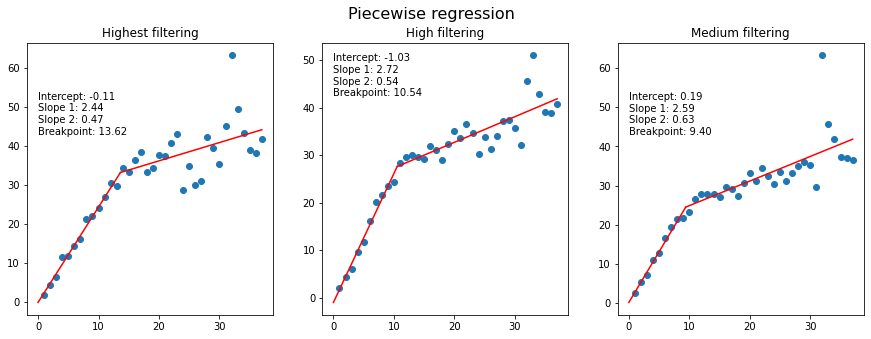

In [41]:
# segmented
def l(x1, x2, y1, slope):
    return slope * (x2 - x1) + y1

def get_lines(intercept, psi1x, mx, u1x):
    break_y = l(0, psi1x, intercept, mx)
    return [
        ((0, psi1x),  # minx, maxx for line 1
        (intercept, break_y)),          # miny, maxy for line 1
        ((psi1x, 37),
        (break_y, l(psi1x, 37, break_y, mx + u1x)))
    ]

fig, ax = plt.subplots(ncols=len(dfs), figsize=(len(dfs) * 5,5))

starts = {
    0: 19,
    1: 11,
    2: 9,
}

for i, item in enumerate(dfs.items()):
    name, df = item
    
    lmodel = _stats.lm("agcd~mode_vals", data=df)
    segmodel = _segmented.segmented(lmodel, segZ="~mode_vals", psi=starts[i])
    psi1x = segmodel.rx2("psi")[0][1]
    intercept, mx, u1x, _ = segmodel.rx2("coefficients")

    ax[i].scatter(df['mode_vals'], df['agcd'])
    maxage = df.mode_vals.max()
    xs = np.arange(0, maxage)
    l1, l2 = get_lines(intercept, psi1x, mx, u1x)
    ax[i].plot(*l1, color='red')
    ax[i].plot(*l2, color='red')
    ax[i].set_title(name)
    text_label = (
        "Intercept: {0:.2f}\n"
        "Slope 1: {1:.2f}\n"
        "Slope 2: {2:.2f}\n"
        "Breakpoint: {3:.2f}\n").format(
            intercept,
            mx,
            mx + u1x,
            psi1x
        )
    ax[i].text(x=0, y=40, s=text_label)

fig.suptitle("Piecewise regression", fontsize=16)